In [1]:
from autodistill_grounding_dino import GroundingDINO
from autodistill.detection import CaptionOntology
import cv2
import supervision as sv
import duckdb
from core_pro.ultilities import make_sync_folder

Importing from timm.models.layers is deprecated, please import via timm.layers


In [23]:
path = make_sync_folder('Item_Matching_Test')
file = path / 'result_match_image/Fashion Accessories__Additional Accessories__Charms, Pendants & Ornaments.parquet'

query = f"""
select * 
from read_parquet('{file}')
"""
df = duckdb.sql(query).pl()
df.head()

shape: (5, 25)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ q_item_id ┆ q_item_na ┆ q_shop_id ┆ q_shop_na ┆ … ┆ db_item_n ┆ db_file_p ┆ db_exists ┆ score_im │
│ ---       ┆ me        ┆ ---       ┆ me        ┆   ┆ ame_clean ┆ ath       ┆ ---       ┆ age_embe │
│ i64       ┆ ---       ┆ i64       ┆ ---       ┆   ┆ ---       ┆ ---       ┆ list[bool ┆ d        │
│           ┆ str       ┆           ┆ str       ┆   ┆ list[str] ┆ list[str] ┆ ]         ┆ ---      │
│           ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆ list[f32 │
│           ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆ ]        │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ 258845566 ┆ Bộ vòng   ┆ 196261835 ┆ Shopee    ┆ … ┆ ["bộ vòng ┆ ["/home/k ┆ [true,    ┆ [1.0,    │
│ 89        ┆ tay DIY   ┆           ┆ Topick    ┆   ┆ tay diy   ┆ evin/Down ┆ true, …   ┆ 0.851722 │
│           ┆ dành cho  ┆           ┆ Global    ┆   ┆ dành cho  ┆ loads/Dat ┆ true]     ┆ , … 0.80 │
│           ┆ trẻ e…    ┆           ┆           ┆   ┆ trẻ…      ┆ a/I…      ┆           ┆ 2366]    │
│ 187811201 ┆ Charm Hạt ┆ 870818171 ┆ MIRA      ┆ … ┆ ["charm   ┆ ["/home/k ┆ [true,    ┆ [1.0,    │
│ 66        ┆ Pan MIRA  ┆           ┆ STORE VN  ┆   ┆ hạt pan   ┆ evin/Down ┆ true, …   ┆ 0.732571 │
│           ┆ & Co.     ┆           ┆           ┆   ┆ mira &    ┆ loads/Dat ┆ true]     ┆ , … 0.67 │
│           ┆ HPA45…    ┆           ┆           ┆   ┆ co. hpa…  ┆ a/I…      ┆           ┆ 8322]    │
│ 273516584 ┆ 20 Cái /  ┆ 365609902 ┆ Enjoyment ┆ … ┆ ["20 cái  ┆ ["/home/k ┆ [true,    ┆ [1.0,    │
│ 75        ┆ túi Thủy  ┆           ┆ .vn       ┆   ┆ / túi     ┆ evin/Down ┆ true, …   ┆ 0.878055 │
│           ┆ Tinh Giả  ┆           ┆           ┆   ┆ thủy tinh ┆ loads/Dat ┆ true]     ┆ , …      │
│           ┆ Ngọ…      ┆           ┆           ┆   ┆ giả n…    ┆ a/I…      ┆           ┆ 0.821]   │
│ 288534776 ┆ (CT679)   ┆ 869327328 ┆ Mori_Blin ┆ … ┆ ["phụ     ┆ ["/home/k ┆ [true,    ┆ [1.0,    │
│ 96        ┆ Phụ Kiện  ┆           ┆ gblingDIY ┆   ┆ kiện      ┆ evin/Down ┆ true, …   ┆ 0.822807 │
│           ┆ Charm     ┆           ┆           ┆   ┆ charm     ┆ loads/Dat ┆ true]     ┆ , … 0.73 │
│           ┆ Hình Ca…  ┆           ┆           ┆   ┆ hình      ┆ a/I…      ┆           ┆ 0502]    │
│           ┆           ┆           ┆           ┆   ┆ capybara… ┆           ┆           ┆          │
│ 272104860 ┆ Bamoer    ┆ 146933636 ┆ Bamoer    ┆ … ┆ ["bamoer  ┆ ["/home/k ┆ [true,    ┆ [1.0,    │
│ 51        ┆ Bạc 925   ┆           ┆ Cửa Hàng  ┆   ┆ bạc 925   ┆ evin/Down ┆ true, …   ┆ 0.834109 │
│           ┆ Quyến Rũ  ┆           ┆ Trang Sức ┆   ┆ quyến rũ  ┆ loads/Dat ┆ true]     ┆ , …      │
│           ┆ Giáng …   ┆           ┆           ┆   ┆ gián…     ┆ a/I…      ┆           ┆ 0.73828] │
└───────────┴───────────┴───────────┴───────────┴───┴───────────┴───────────┴───────────┴──────────┘

In [24]:
run_q = df[['q_item_name', 'q_category', 'q_file_path']].to_dicts()
run_q[1]

{'q_item_name': 'Charm Hạt Pan MIRA & Co. HPA45 Pan Trụ Tròn Tim Mạ Bạc Xi Bạc Mix Được Tất Cả Dòng Lắc MIRA',
 'q_category': 'Fashion Accessories__Additional Accessories__Charms, Pendants & Ornaments',
 'q_file_path': '/home/kevin/Downloads/Data/Item_Matching_Test/download_img_Fashion/img_/00000/0000000078.jpg'}

In [25]:
run_db = df[['db_item_name', 'db_category', 'db_file_path', 'score_image_embed']].to_dicts()[:2]
run_db[1]

{'db_item_name': ['Charm Hạt Pan MIRA & Co. HPA45 Pan Trụ Tròn Tim Mạ Bạc Xi Bạc Mix Được Tất Cả Dòng Lắc MIRA',
  'Charm Hạt Pan MIRA & Co. Charm Trending Dễ Mix Chất Liệu Xi Bạc Mạ Bạc Mix Được Tất Cả Dòng Lắc MIRA',
  '[Hàng cao cấp] Charm bạc 925 cao cấp, bộ tổng hợp các mẫu charm bạc DNJ để mix vòng charm - Bộ sản phẩm từ DN65 đến DN80',
  'DISNEY PANDORA Hạt Charm Mạ Bạc 925 Hình Vương Miện Chữ O Lấp Lánh Trang Trí Vòng Tay Xinh Xắn',
  'Charm bạc 925 cao cấp, bộ tổng hợp các mẫu charm bạc DNJ để mix vòng charm - Bộ sản phẩm từ DN129 đến DN144',
  'Chảo Mạ Bạc 925 Chất Lượng Cao | Mặt Dây Chuyền Mạ Vàng Hồng 18k Nhiều Kiểu Dáng Độc Đáo | Mặt Dây Chuyền Hình Lâu Đài Đính Hạt Dễ Thương',
  'Charm Bạc Thái S925 - Hạt Charm để mix Vòng tay Charm Lake Baikal 1691',
  'Charm TITAN Hạt Pan MIRA & Co. CHT16 Charm Hạt Đá Zicon Vô Cực Chất Liệu TITAN Không Hoen Gỉ',
  '( Hàng Có Sẵn ) Charm Pan Ale Bạc S925 Hoạ Tiết Nhiều Mẫu Chiếc Bánh , Trăng Sao , Vũ Trụ',
  'Charm Hạt Pan MIRA & Co. HP

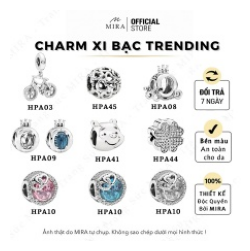

In [26]:
sv.plot_image(cv2.imread(run_q[1]['q_file_path']), size=(3, 3))

In [32]:
from collections import defaultdict


box_lst, crop_lst = [], defaultdict(list)
for lst_match in run_db[1:]:
    for c, p in zip(lst_match['db_category'], lst_match['db_file_path']):
        # item_ = c.split('__')[-1]
        item = 'Charms'
        img_path = p
        base_model = GroundingDINO(ontology=CaptionOntology({f"{item_}": f"{item_}"}))
        result = base_model.predict(img_path)

        # plot
        box_annot = sv.BoxAnnotator()
        image = cv2.imread(img_path)
        img_annot = box_annot.annotate(scene=image.copy(), detections=result)
        box_lst.append(img_annot)

        # crop
        for i in result.xyxy:
            crop_img = sv.crop_image(image=image.copy(), xyxy=i)
            crop_lst.append(crop_img)
        # break
    break

trying to load grounding dino directly
final text_encoder_type: bert-base-uncased


You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
The `device` argument is deprecated and will be removed in v5 of Transformers.
torch.utils.checkpoint: the use_reentrant parameter should be pas

ValueError: too many values to unpack (expected 4)

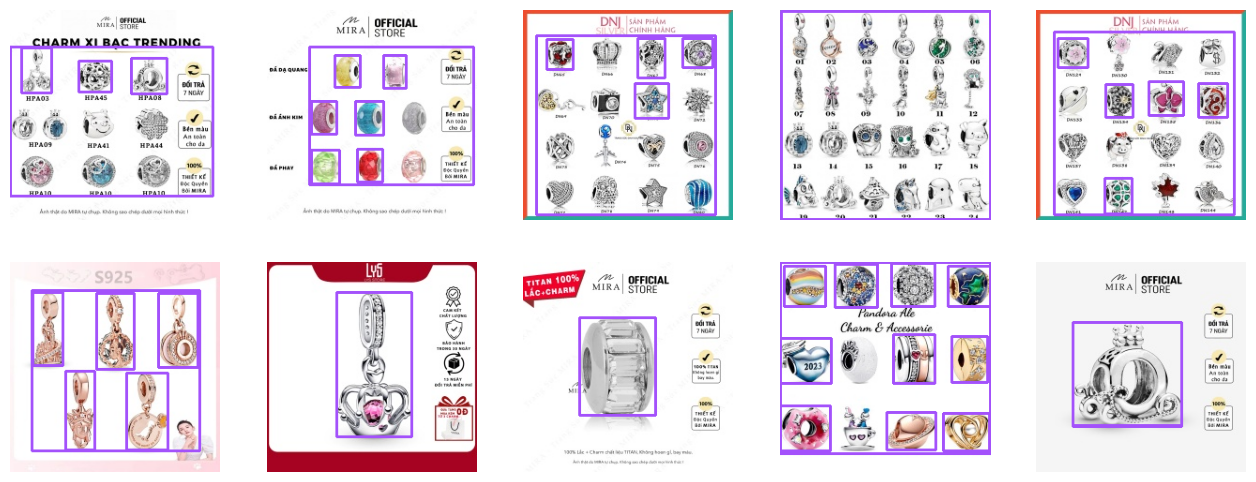

In [31]:
sv.plot_images_grid(match, grid_size=(2, 5), size=(16, 6))

In [10]:
match[0].shape

(224, 224, 3)

In [29]:
item_

'Charms, Pendants & Ornaments'